# Anomaly detection in faces using VQ-VAE

This notebook is in addition to the blogpost a tool to guide you through the research we performed inspired on the work of Marimont et al. on Anomaly detection through latent space restoration using VQ-VAE [1]. The purpose of this notebook is not to explain all the theoretical components of the research, rather it is to provide a step-by-step guide to obtain results on a toy data set in the form of snippets of code. This is done with the intention to deliver a greater understanding of the topic covered and to give a broad idea of the pipeline.
The notebook can be seen as a demo for FFHQ and for FaceForensics++. We show both the same visualisations but on the two different datasets. You can play with threshold values and see what happens. This will be made clear once relevant.

## Imports

NOTE: the imports cell block is going to ask you to authorise yourself for the use of WANDB. Click the link provided in the output and copy the code on the page. Use this code to authorise and it will say:

```wandb: Currently logged in as: "user" (vqvaeanomaly). Use `wandb login --relogin` to force relogin```

In [4]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import nets_LV
import nets_AR
import utils

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Fake and real faces demo

Here we will show a DEMO of the fake and real face dataset, which consists of real FFHQ faces and photoshopped ones. First, we go over the preparation steps then we give you some predictions of the model and reconstructions. Finally, a localisation method of resampled samples will be shown, highlighting the areas of the image where to model thinks an anomaly occured.

## Initialize models with pretrained weights

In [4]:
#Load the checkpoints of the VQ-VAE and the PixelSnail.
vqvae_checkpoint_path = '../AnomalyDetection/src/DeepFake/checkpoints/ffhq/vqvae.pt'
ar_checkpoint_path = '../AnomalyDetection/src/DeepFake/checkpoints/ffhq/ar.pt'

vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

#Define the models
vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vq_model.load_state_dict(vqvae_checkpoint["model"])
vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_model.load_state_dict(ar_checkpoint['model'])
ar_model = ar_model.to(device)

## FFHQ 512 & Real/Fake faces dataset

In [5]:
#This is during training the variable we use to insert augmentations, for now we will just make a tensor out of the images.
transform_pipeline = transforms.Compose([
    transforms.ToTensor()
])

#Path to toy dataset
demo_data_path_ffhq = '../AnomalyDetection/src/DeepFake/demo/demo_data/FFhq_toy'

#Create the image class and dataloader.
demo_dataset = ImageFolder(demo_data_path_ffhq, transform=transform_pipeline)
demo_dataloader = DataLoader(demo_dataset, batch_size=3, shuffle=False)

## Sample-wise score

Feel free to change the 'threshold' values to see how the results will change.

Since we use 'loss' to understand whether the sample is anomalous, a bigger loss == higher probablity that there is an anomaly in the image. That implies that a higher score value means that there exists an anomaly on the image.

In [6]:
#Change this to adjust when the model labels the image as anomalous.
threshold = 7

pred = []

ar_model.eval()
for X, _ in tqdm(demo_dataloader):
    with torch.no_grad():
        X=X.to(device)
        loss = ar_model.loss(X, reduction='none')['loss'].flatten(1)
        
        score = torch.sum(loss*(loss>threshold), 1).float()
        pred.append(score.cpu().numpy())

100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Plot the images with the corresponding sample-wise score. The lower the sample-wise score the less likely the image is anomalous according to the model.

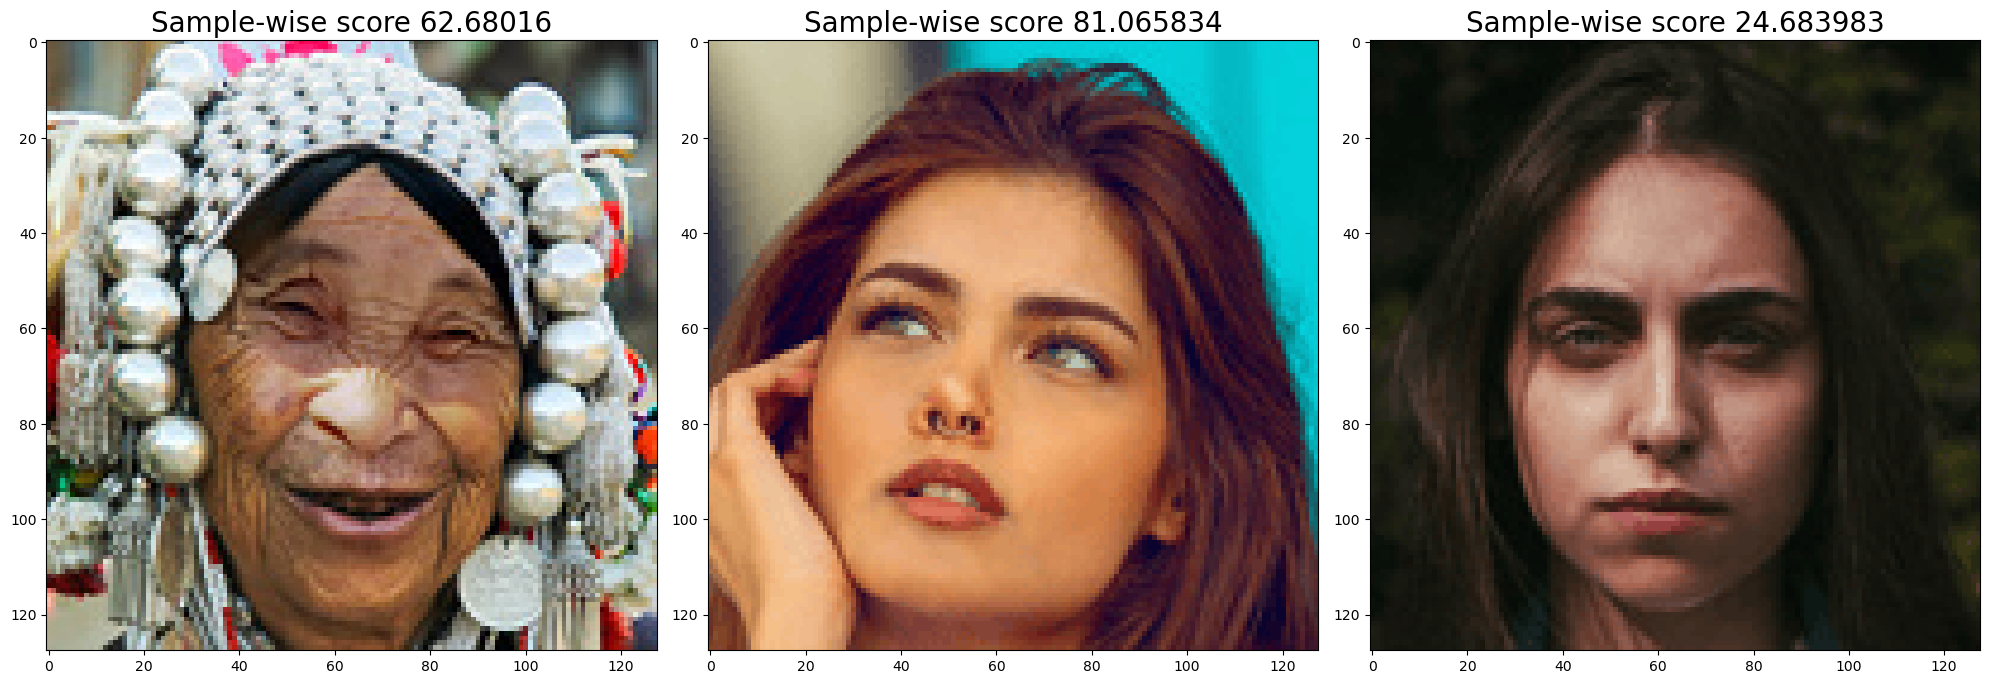

In [9]:
X = next(iter(demo_dataloader))[0]
fix, axes = plt.subplots(1,3, figsize=(20,10))

axes[0].imshow(X[0].permute(1,2,0))
axes[0].set_title('Sample-wise score '+ str(pred[0][0]), + " (fake)", fontsize=20)
axes[1].imshow(X[1].permute(1,2,0))
axes[1].set_title('Sample-wise score '+ str(pred[0][1]) + " (fake)",fontsize=20)
axes[2].imshow(X[2].permute(1,2,0))
axes[2].set_title('Sample-wise score '+ str(pred[0][2]) + " (real)",fontsize=20)

plt.tight_layout()
plt.show()

In the visualisation above, the first 2 images are photoshopped (first is from easy category and the second from hard). The third image is a real face. The first image is modified around the eyes and nose area, the second only the node is modified. The model's prediction nicely aligns with the ground truth.

## Reconstructing images

Following codeblock is the function we use to show reconstructions of the models after resampling according to given threshold. The user can play with this threshold and see the effect it has on the reconstructions. The lower the threshold the more get resampled.

In [10]:
def reconstruct(n, img, threshold_log_p = 5):
    """ Generates n reconstructions for each image in img.
    Resamples latent variables with cross-entropy > threshold
    Returns corrected images and associated latent variables"""
    #Use VQ-VAE to encode original image
    codes = ar_model.retrieve_codes(img)
    
    code_size = codes.shape[-2:]
   
    with torch.no_grad():
        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)
    
        if not threshold_log_p == None:
            #The main for loop to resample latent code
            for r in tqdm(range(code_size[0])):
                for c in range(code_size[1]):        

                    code_logits = ar_model.forward_latent(samples)[:,:,r,c]
                    loss = F.cross_entropy(code_logits, samples[:, r, c], reduction='none')
                    probs = F.softmax(code_logits, dim=1)
                    #Only resample the the indices that have higher loss than the threshold
                    samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]

        z = vq_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        

        x_tilde = []
        #For loop for decoding the newly samples latent codes.
        for i in range(img.shape[0]):
            predict = vq_model.decode(z[i*n:(i+1)*n])
            x_tilde.append(predict)

        x_tilde = torch.cat(x_tilde)

    return x_tilde.reshape(img.shape[0], n, img.shape[1],*img.shape[-2:])


In [11]:
#Adjust this threshold to define how sensitive the model is to resampling latent codes.
threshold_log=8

reconstructions = []
for X,y in demo_dataloader:
    X = torch.Tensor(X).to(device)
    #We create 15 reconstructions per image and average across them to get low variance results.
    out = reconstruct(n=15,img=X.float(), threshold_log_p=threshold_log)
    out = torch.mean(out, dim=1)
    reconstructions.append(out)
    


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


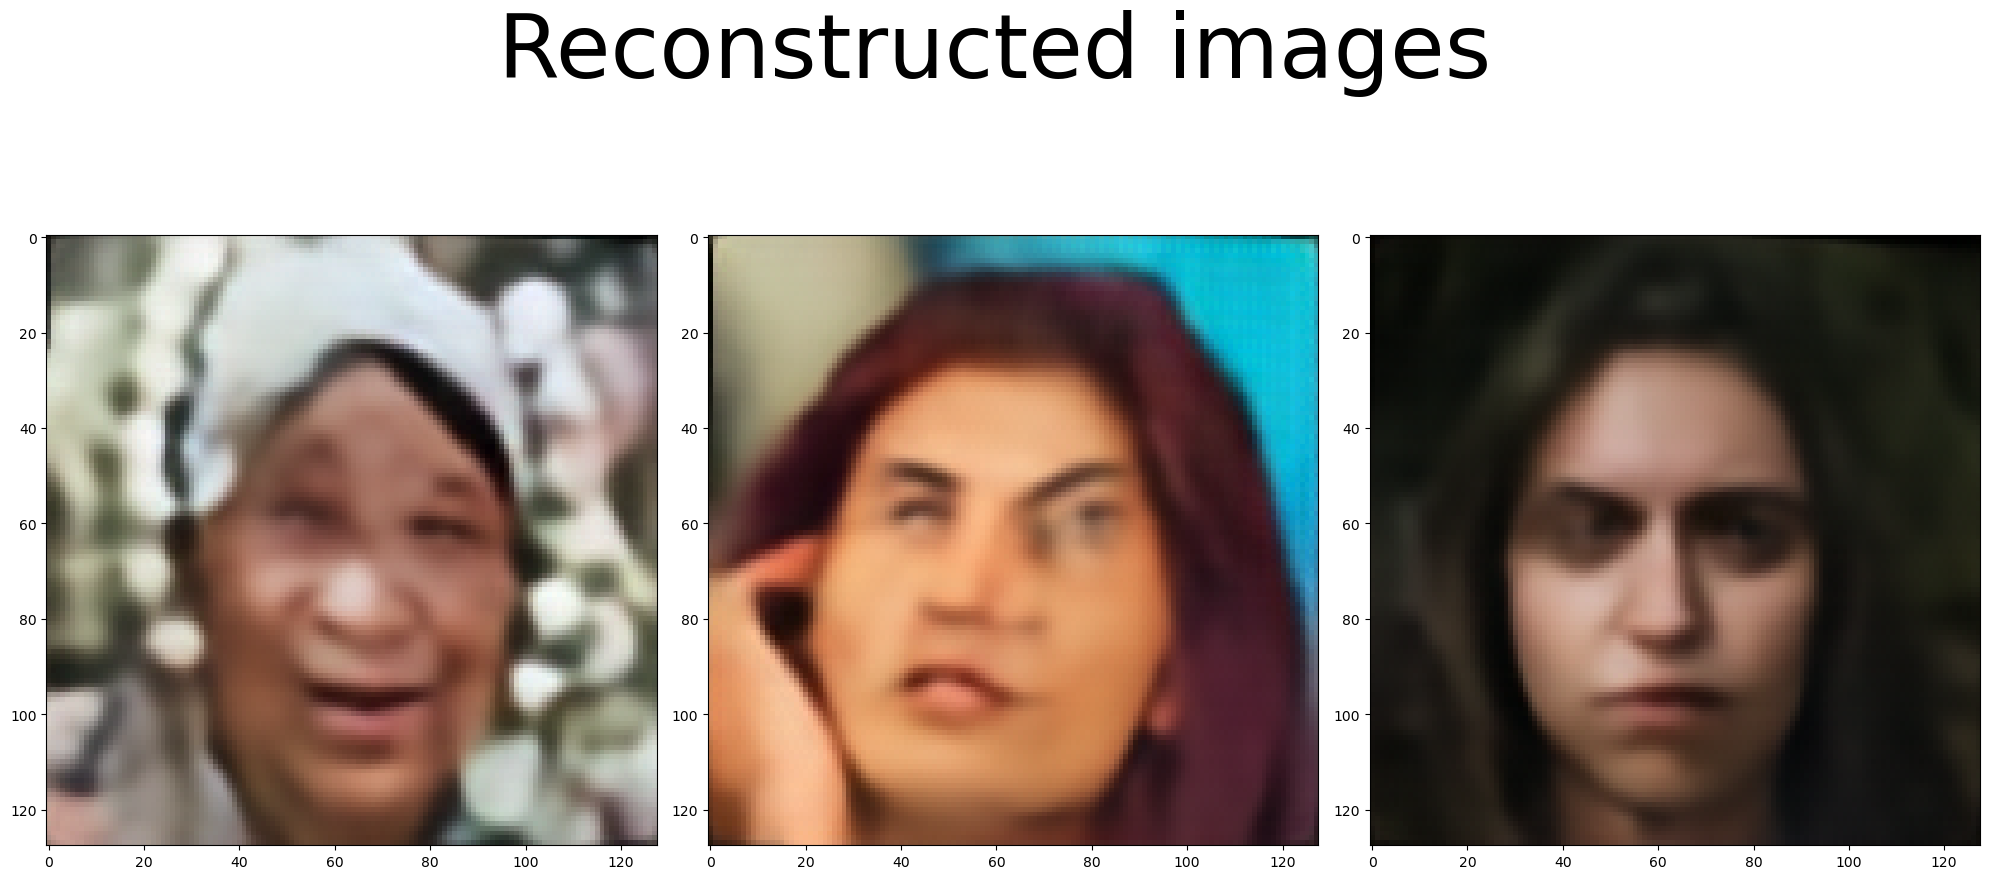

In [12]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
fig.suptitle('Reconstructed images', fontsize=64)

axes[0].imshow(reconstructions[0][0].squeeze().permute(1,2,0).cpu())
axes[1].imshow(reconstructions[0][1].squeeze().permute(1,2,0).cpu())
axes[2].imshow(reconstructions[0][2].squeeze().permute(1,2,0).cpu())

plt.tight_layout()
plt.show()

## Differences between inputs and outputs

The following codeblocks are about showing the pixels that are different in the original image compared to the reconstructions. We can show this by subtracting the reconstructed image from the original images and show the "heatmap" that results from this operation. This is a clear visualisation of the locations where the model finds anomalies.

In [14]:
def calc_diffs(input, tilde):
    diff = torch.abs(input.to(device).float()-tilde)

    # Calculate restoration weight based on restoration similarity to original image
    sim_imgwise = torch.mean(diff,(1,2)).unsqueeze(1).unsqueeze(2)
    sim_imgwise = torch.softmax(sim_imgwise,0)

    # Pixel-wise score after weight 
    diff = (diff*sim_imgwise).sum(0,keepdims=True)
    return diff

old_woman_diff = calc_diffs(X[0], reconstructions[0][0]).permute(1,2,0).cpu()
young_woman_diff = calc_diffs(X[1], reconstructions[0][1]).permute(1,2,0).cpu()
man_diff = calc_diffs(X[2], reconstructions[0][2]).permute(1,2,0).cpu()

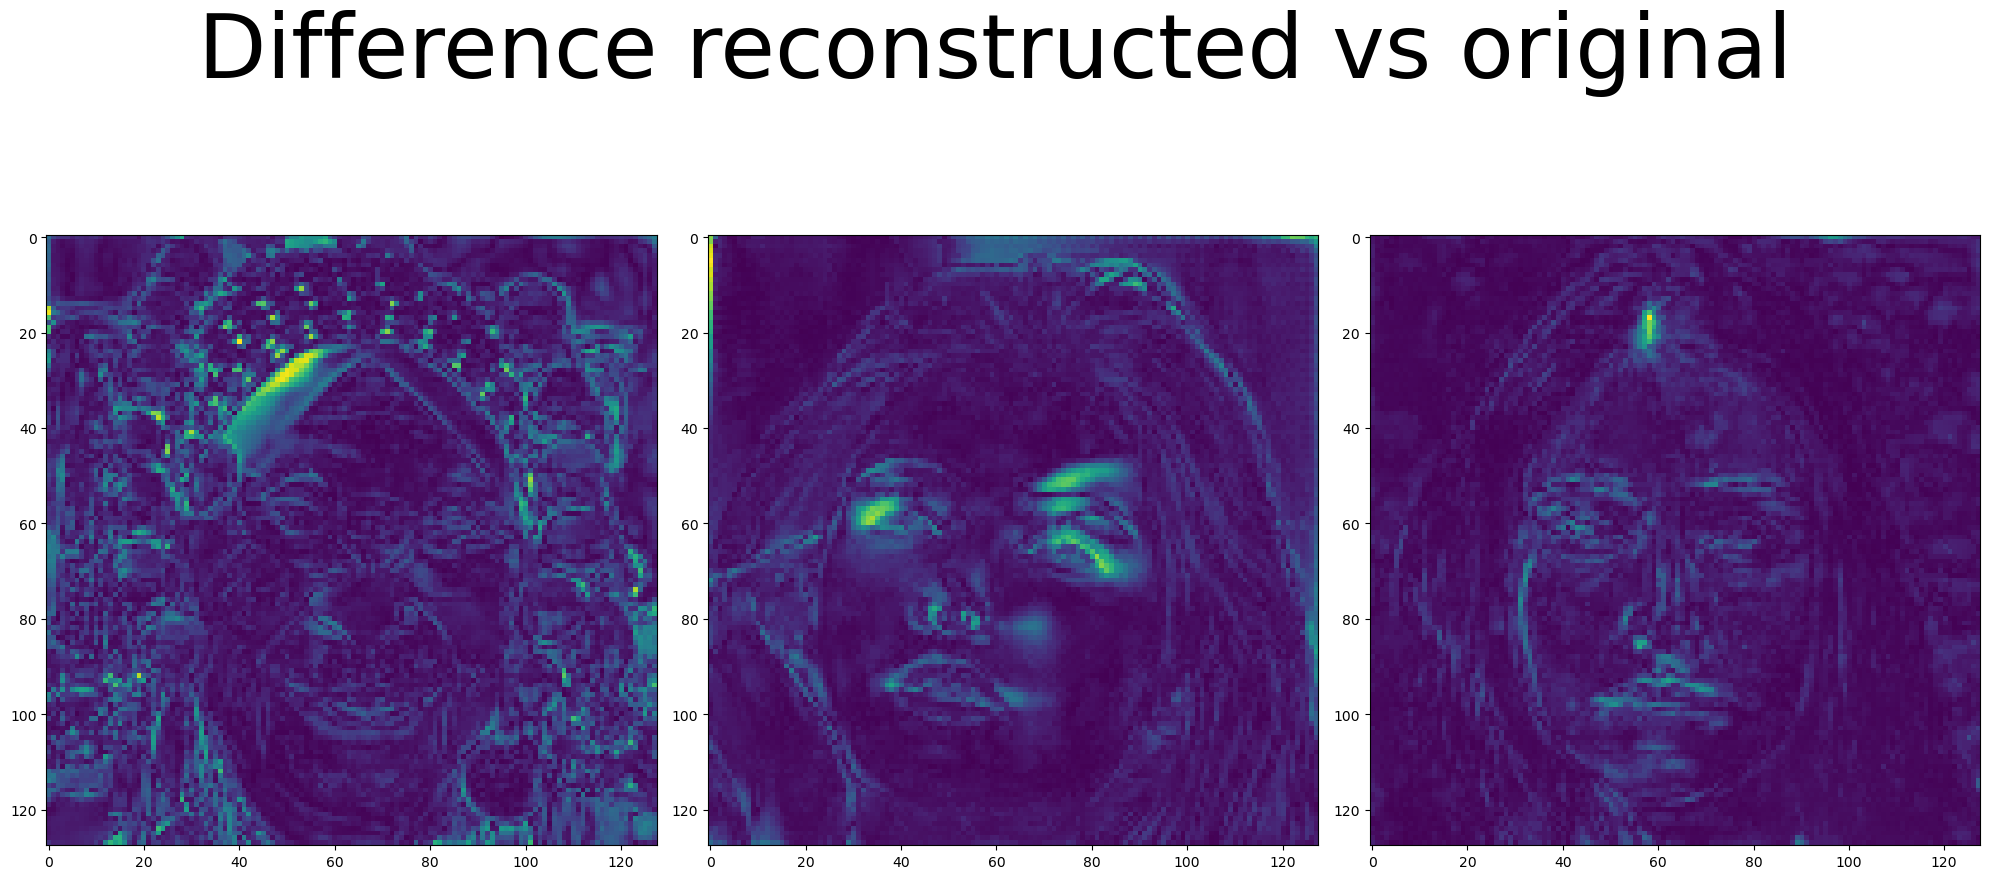

: 

In [15]:
fix, axes = plt.subplots(1,3, figsize=(20,10))
fix.suptitle('Difference reconstructed vs original', fontsize=64)
axes[0].imshow(old_woman_diff)
axes[0].set_title('')
axes[1].imshow(young_woman_diff)
axes[1].set_title('')
axes[2].imshow(man_diff)
axes[2].set_title('')

plt.tight_layout()
plt.show()

Note that the rightmost face is a real one, the two before are modified. Some interesting obervations can be made. For the first face we see that resampling happened more on the top of the head. The accessories of the woman's clothing were detected as outliers and the main reason for higher sample-wise score. For the middle face we see that the eyes were detected as anomalous, and we see some parts of the nose-ring light up. The reason for the eyes could be that the woman is looking away from the camera and at a slight angle, which is different from the prior learnt. Finally the last real face is mostly what should be expected, low activity.

# FaceForensics ++ demo

Next we show similar steps but for the face forensics++ dataset. NOTE: that faceforensics is only accessible after signing up for it. For the purposes of this DEMO we provide you with a toy set of preprocessed faceforensics++ images.

## Initialize models with pretrained weights

In [5]:
vqvae_checkpoint_path = '../AnomalyDetection/src/DeepFake/checkpoints/faceforensics/vqvae.pt'
vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)

ar_checkpoint_path = '../AnomalyDetection/src/DeepFake/demo/checkpoints/faceforensics/ar.pt'
ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vq_model.load_state_dict(vqvae_checkpoint["model"])
vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_model.load_state_dict(ar_checkpoint['model'])
ar_model = ar_model.to(device)

## FaceForensics++ data

In [6]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor()
])

demo_data_path_forensic = '../AnomalyDetection/src/DeepFake/demo/demo_data/forensic_toy'

demo_dataset = ImageFolder(demo_data_path_forensic, transform=transform_pipeline)
demo_dataloader = DataLoader(demo_dataset, batch_size=3, shuffle=False)

## Sample-wise score

In [7]:
threshold = 7

pred = []

ar_model.eval()
for X, _ in tqdm(demo_dataloader):
    with torch.no_grad():
        X=X.to(device)
        loss = ar_model.loss(X, reduction='none')['loss'].flatten(1)
        
        score = torch.sum(loss*(loss>threshold), 1).float()
        pred.append(score.cpu().numpy())

100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


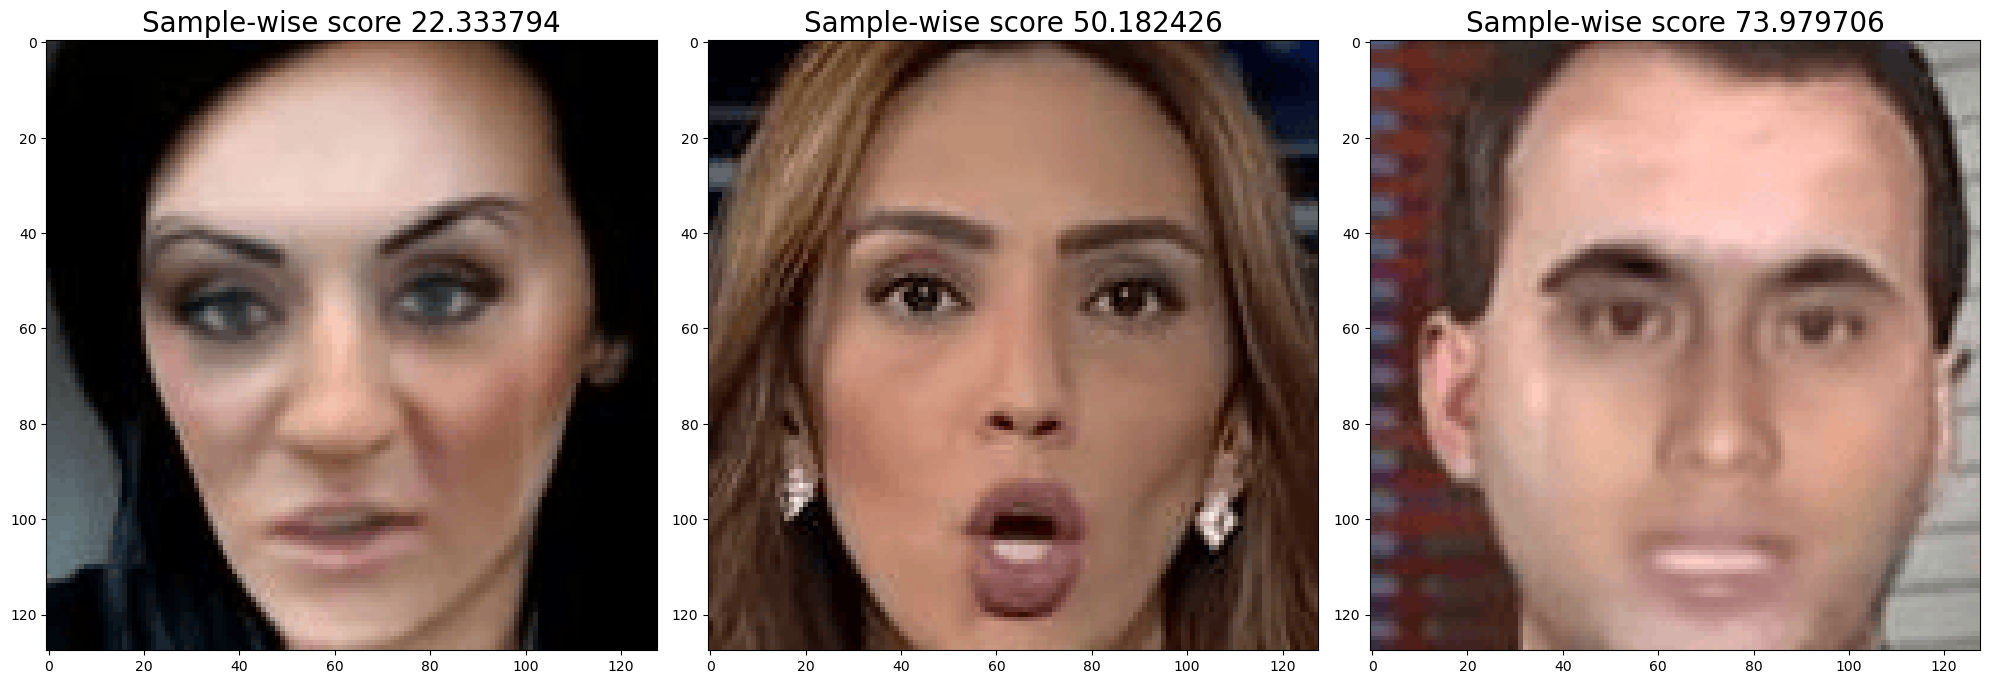

In [8]:
X = next(iter(demo_dataloader))[0]
fix, axes = plt.subplots(1,3, figsize=(20,10))
axes[0].imshow(X[0].permute(1,2,0))
axes[0].set_title('Sample-wise score '+ str(pred[0][0]), fontsize=20)
axes[1].imshow(X[1].permute(1,2,0))
axes[1].set_title('Sample-wise score '+ str(pred[0][1]), fontsize=20)
axes[2].imshow(X[2].permute(1,2,0))
axes[2].set_title('Sample-wise score '+ str(pred[0][2]), fontsize=20)

plt.tight_layout()
plt.show()

## FaceForensics reconstructions

In [12]:
def reconstruct(n, img, threshold_log_p = 5):
    """ Generates n reconstructions for each image in img.
    Resamples latent variables with cross-entropy > threshold
    Returns corrected images and associated latent variables"""
    #Use VQ-VAE to encode original image
    codes = ar_model.retrieve_codes(img)
    
    code_size = codes.shape[-2:]
   
    with torch.no_grad():
        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)
    
        if not threshold_log_p == None:
            #The main for loop to resample latent code
            for r in tqdm(range(code_size[0])):
                for c in range(code_size[1]):        

                    code_logits = ar_model.forward_latent(samples)[:,:,r,c]
                    loss = F.cross_entropy(code_logits, samples[:, r, c], reduction='none')
                    probs = F.softmax(code_logits, dim=1)
                    #Only resample the the indices that have higher loss than the threshold
                    samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]

        z = vq_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        

        x_tilde = []
        #For loop for decoding the newly samples latent codes.
        for i in range(img.shape[0]):
            predict = vq_model.decode(z[i*n:(i+1)*n])
            x_tilde.append(predict)

        x_tilde = torch.cat(x_tilde)

    return x_tilde.reshape(img.shape[0], n, img.shape[1],*img.shape[-2:])

In [13]:
reconstructions = []
for X,y in demo_dataloader:
    X = torch.Tensor(X).to(device)
    out = reconstruct(n=15,img=X.float(), threshold_log_p=8)
    out = torch.mean(out, dim=1)
    reconstructions.append(out)


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


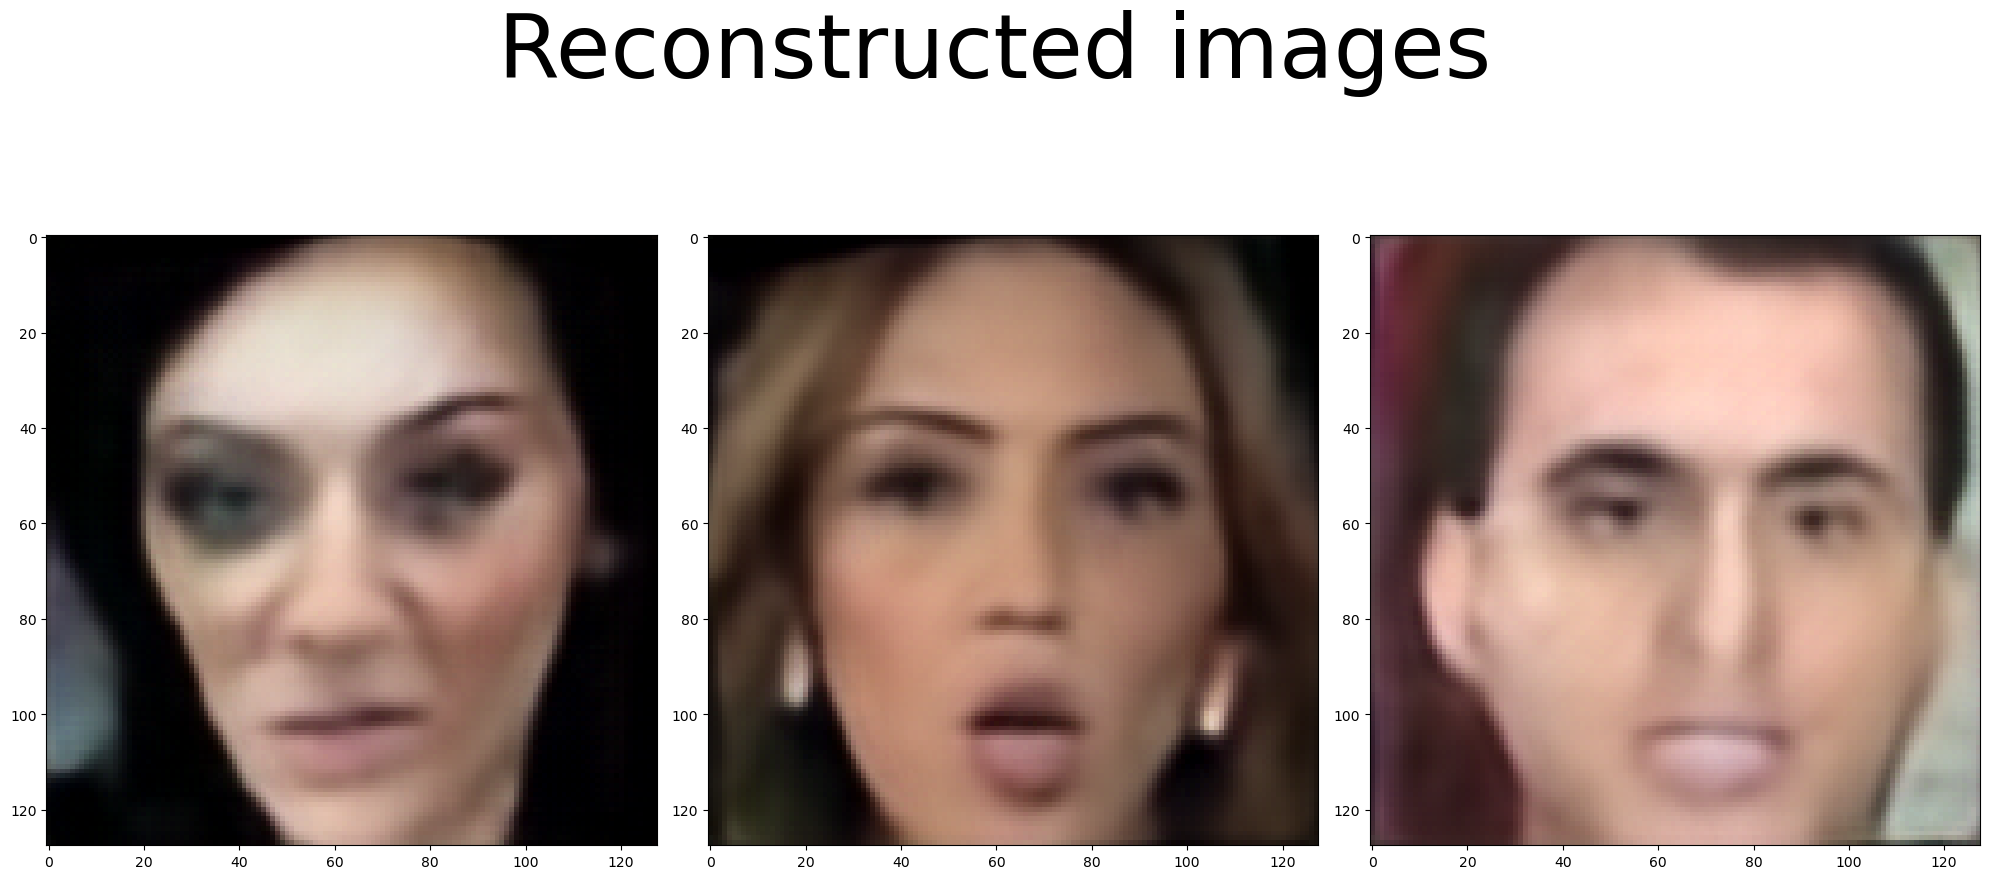

In [16]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
fig.suptitle('Reconstructed images', fontsize=64)

axes[0].imshow(reconstructions[0][0].squeeze().permute(1,2,0).cpu())
axes[1].imshow(reconstructions[0][1].squeeze().permute(1,2,0).cpu())
axes[2].imshow(reconstructions[0][2].squeeze().permute(1,2,0).cpu())

plt.tight_layout()
plt.show()

## Differences between inputs and outputs

In [17]:
def calc_diffs(input, tilde):
    diff = torch.abs(input.to(device).float()-tilde)

    # Calculate restoration weight based on restoration similarity to original image
    sim_imgwise = torch.mean(diff,(1,2)).unsqueeze(1).unsqueeze(2)
    sim_imgwise = torch.softmax(sim_imgwise,0)

    # Pixel-wise score after weight 
    diff = (diff*sim_imgwise).sum(0,keepdims=True)

    return diff

old_woman_diff = calc_diffs(X[0], reconstructions[0][0]).permute(1,2,0).cpu()
young_woman_diff = calc_diffs(X[1], reconstructions[0][1]).permute(1,2,0).cpu()
man_diff = calc_diffs(X[2], reconstructions[0][2]).permute(1,2,0).cpu()

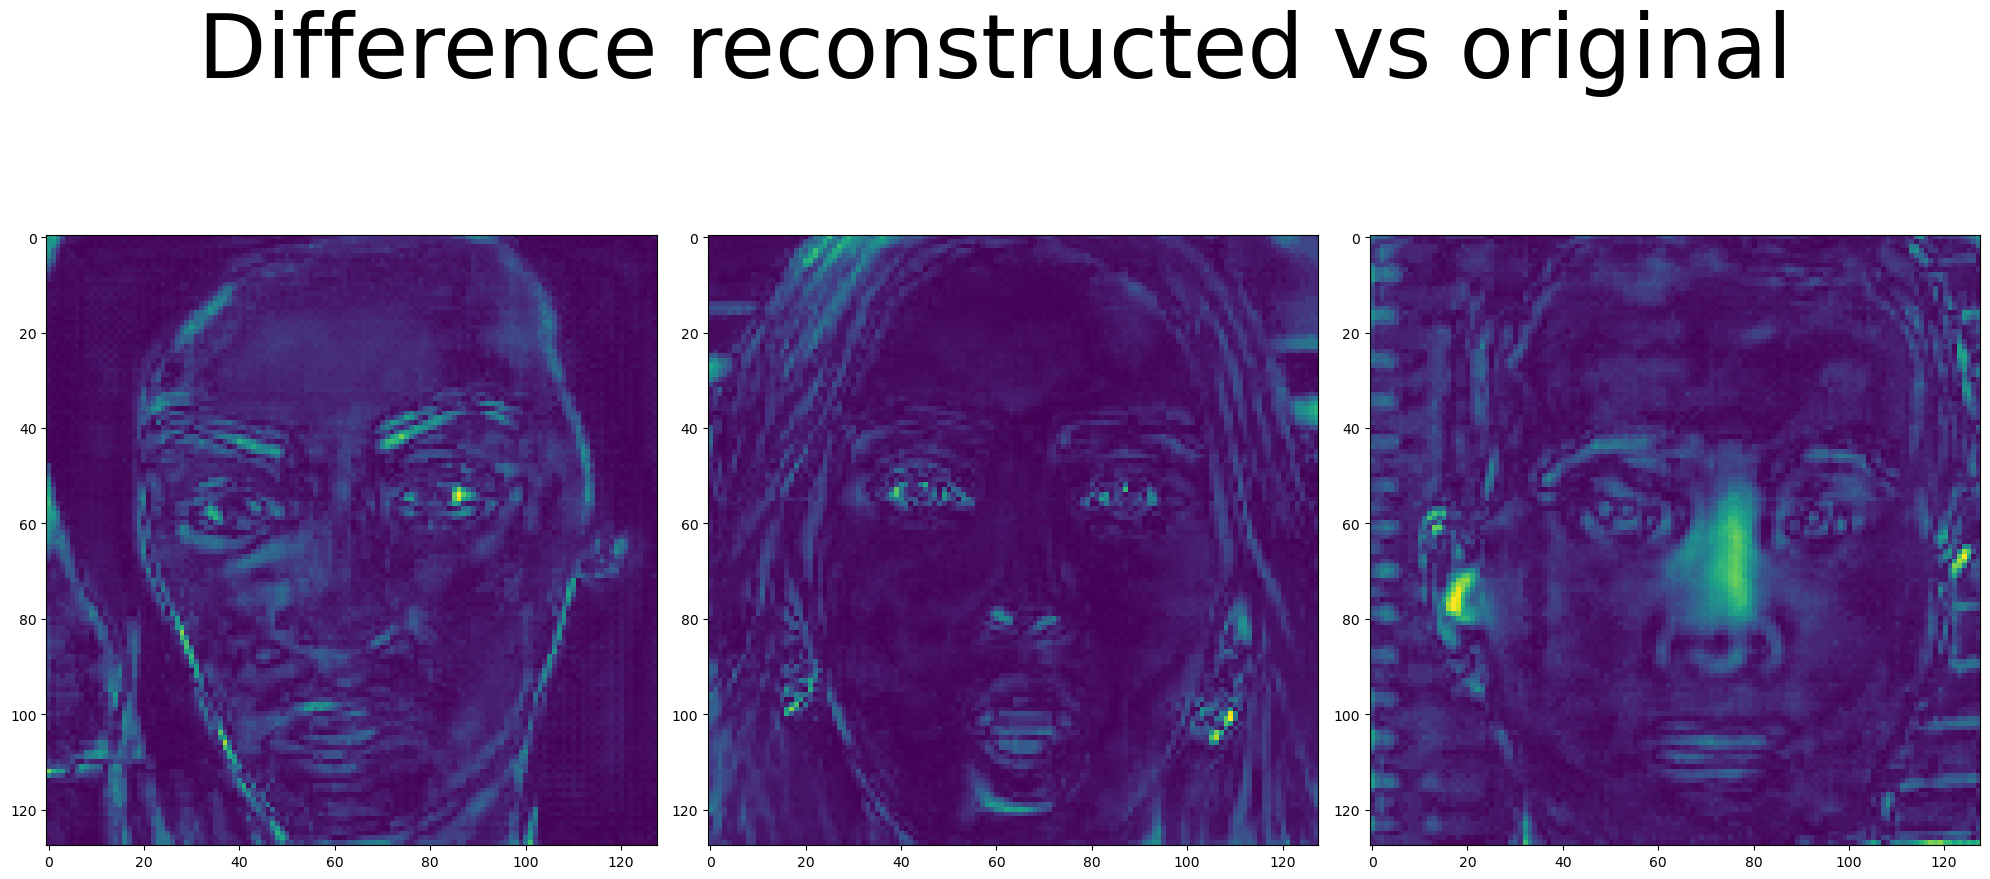

In [18]:
fix, axes = plt.subplots(1,3, figsize=(20,10))
fix.suptitle('Difference reconstructed vs original', fontsize=64)
axes[0].imshow(old_woman_diff)
axes[0].set_title('')
axes[1].imshow(young_woman_diff)
axes[1].set_title('')
axes[2].imshow(man_diff)
axes[2].set_title('')

plt.tight_layout()
plt.show()

In the first face we can see how some parts of the eye and left eyebrow are being resampled, and actually being fixed in the restoration process. The face in the middle is a real face so we expect low resampling activity. Finally the 3rd face we can see nicely how the model finds the artefacts as a result of modifications and resamples those cases.